In [1]:
import agama
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import yaml
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('../analysis/my_standard.mplstyle')

%matplotlib inline
import numpy as np
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

agama.setUnits(length=u.kpc, mass=u.Msun, time=u.Myr)

I'm more used to the Gala interface for creating potential models, so for this example I make a Gala NFW model and then convert to Agama:

 - Updated the potential to match Lilleegen+23 (r_s = 12.8kpc, c = 15.3, v_c_solar = 184 km/s, V_vir = ˜130 km/s)

In [2]:
import pathlib
from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


In [5]:
# def NFW_200(self, Mvir, cvir, z=0):
#     c200 = self.cvirc200(cvir=cvir, z=z)
#     M200 = Mvir * self.m200mvir(c200, cvir)
#     return M200, c200

In [3]:
gala_pot = gp.NFWPotential.from_M200_c(M200=6.5e11*u.Msun, c=25, units=galactic, origin=np.array(Model.expansion_centres(0.))[3:6])
# from_circular_velocity(
#     v_c=184 * u.km / u.s, r_s=8.2 * u.kpc, units=galactic)
agama_pot = gala_pot.as_interop("agama")

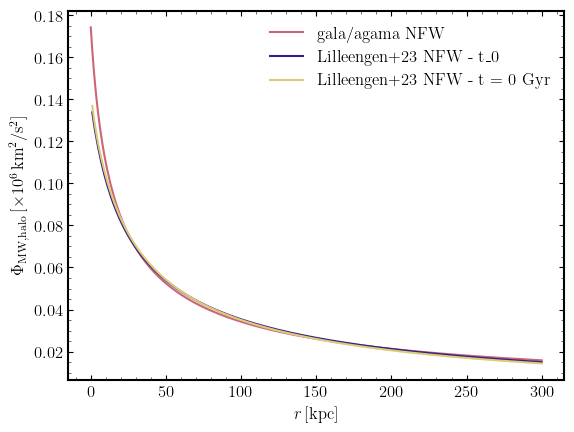

In [4]:
rs = np.linspace(0,300, 300)
empty = np.zeros(shape=(len(rs),3))
empty[:,0] = rs

sl_nfw_0 = -Model.mwhalo_fields(-3., empty[:,0], empty[:,1], empty[:,2], 0)[:,4]
sl_nfw_f = -Model.mwhalo_fields(-0., empty[:,0], empty[:,1], empty[:,2], 0)[:,4]
agama_nfw = -agama_pot.potential(empty)

# plt.plot(rs, gala_pot.circular_velocity(empty.T))
plt.plot(rs, agama_nfw, label='gala/agama NFW')
plt.plot(rs, sl_nfw_0/1e6, label='Lilleengen+23 NFW - t_0')
plt.plot(rs, sl_nfw_f/1e6, label='Lilleengen+23 NFW - t = 0 Gyr')
plt.xlabel(r'$r\,[\mathrm{kpc}]$')
plt.ylabel(r'$\Phi_{\mathrm{MW, halo}}\,[\times 10^{6}\,\mathrm{km}^2 / \mathrm{s}^2]$')
plt.legend(frameon=False)
# print(gala_pot.circular_velocity(np.array([195,0,0])))

agama.Potential(type="...", mass=..., otherParameters=...)We don't need to generate samples from a self-consistent DF, so we can pick any density profile we want for the tracers we will sample. Here the "tracers" are the positions and velocities of the stream progenitors. We'll use a Dehnen (power law) model with a scale radius in kpc:

In [5]:
dens = agama.Density(type="Dehnen", scaleRadius=20)

For the DF (i.e. the energy distribution), we use a quasi-spherical, isotropic Osipkov-Merritt model:

In [6]:
df = agama.DistributionFunction(
    type="QuasiSpherical", potential=agama_pot, density=dens)

In [7]:
gm = agama.GalaxyModel(agama_pot, df)

Generate 10,000 samples from this DF:

In [9]:
Nsamples = 1000 #24
xv = gm.sample(Nsamples)[0]

Generate some mock masses and scale radii for the progenitors

In [10]:
# np.random.seed(1)

# # Masses

# mu_low_mass, mu_high_mass = 1_0000, 1_000_000 #solar masses 
# std_low_mass, std_high_mass = mu_low_mass**0.5, mu_high_mass**0.5

# samples_low_mass = np.random.normal(mu_low_mass, std_low_mass, int(Nsamples/2))
# samples_high_mass = np.random.normal(mu_high_mass, std_high_mass, int(Nsamples/2))
# prog_masses = np.concatenate((samples_low_mass, samples_high_mass))[:,np.newaxis]

# # Scale radii

# mu_low_scale, mu_high_scale = 0.005, 0.5 #kpc
# std_low_scale, std_high_scale = 0.001, 0.1

# samples_low_scale = np.random.normal(mu_low_scale, std_low_scale, int(Nsamples/2))
# samples_high_scale = np.random.normal(mu_high_scale, std_high_scale, int(Nsamples/2))
# prog_scales = np.concatenate((samples_low_scale, samples_high_scale))[:,np.newaxis]

# prog_mass_scale = np.concatenate([prog_masses, prog_scales], axis=1)

# np.random.shuffle(prog_mass_scale)

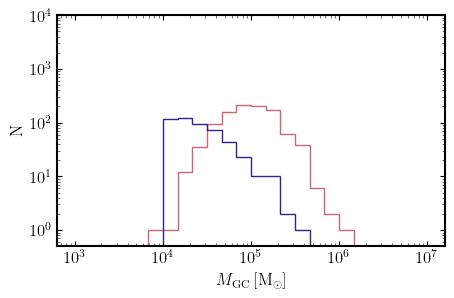

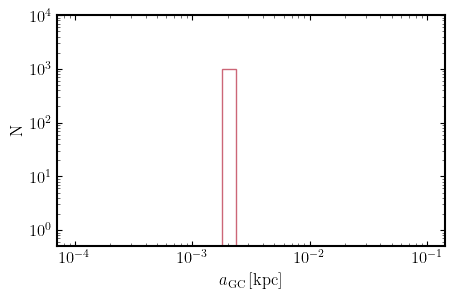

In [11]:
rng = np.random.default_rng(seed=1)

# Masses
mu_mass = np.log(1e5) #solar masses 
std_mass = np.log(2)
samples_mass = rng.lognormal(mu_mass, std_mass, Nsamples)[:,np.newaxis]


lower_bound = 1e4
upper_bound = 1e7
mu_mass_init = np.log(1e4) #solar masses 
std_mass_init = np.log(3)
samples_mass_init = rng.lognormal(mu_mass_init, std_mass_init, Nsamples)[:,np.newaxis]
truncated_samples = samples_mass_init[(samples_mass_init > lower_bound) & (samples_mass_init < upper_bound)]

plt.figure(figsize=(5,3))
plt.hist(samples_mass, histtype='step',bins=np.logspace(np.log(1e3), np.log(1e7), num=25, base=np.e))
plt.hist(truncated_samples, histtype='step',bins=np.logspace(np.log(1e3), np.log(1e7), num=25, base=np.e))

plt.xscale('log')
plt.yscale('log')
plt.ylim(0.5, 1e4)
plt.ylabel('N')
plt.xlabel(r'$M_{\mathrm{GC}}\,[\mathrm{M}_{\odot}]$')


# Scale radii
mu_scale = np.log(2e-3) #kpc
std_scale = np.log(1)

samples_scale = rng.lognormal(mu_scale, std_scale, Nsamples)[:,np.newaxis]

plt.figure(figsize=(5,3))
plt.hist(samples_scale, histtype='step',bins=np.logspace(np.log(1e-4), np.log(1e-1), num=25, base=np.e))
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.5, 1e4)
plt.ylabel('N')
plt.xlabel(r'$a_{\mathrm{GC}}\,[\mathrm{kpc}]$')

prog_mass_scale = np.concatenate([samples_mass, samples_scale], axis=1)

The positions and velocities in what is returned are in 6-vectors with pos in kpc, vel in kpc/Myr. I have a class in Gala for interacting with phase-space coordinates like this:

In [12]:
mwh0_xv = np.concatenate( (np.array(Model.expansion_centres(0.)[3:6]),
               np.array(Model.expansion_centre_velocities(0.)[3:6])*(u.km/u.s).to(u.kpc/u.Myr) ) )

In [13]:
w0 = gd.PhaseSpacePosition.from_w(xv.T + mwh0_xv[:, None], units=galactic)

Whenever I sample from a DF, I like to just verify that the samples succeeded. One check we can make is that if we integrate the orbits of the tracers, the distribution at the final orbital timestep looks the same as the initial distribution. I use Gala to do the orbit integration (`store_all=False` tells Gala not to store all of the intermediate timesteps, and it just integrates all of the orbits to the final time and returns that):

In [48]:
def F_rigid(t, w, m200, c200):
        origin_halo = np.array(Model.expansion_centres(t/1e3))[3:6]
        pot = gp.NFWPotential.from_M200_c(M200=m200, c=c200, units=galactic, origin=origin_halo)   

        wdot = np.zeros_like(w)
        wdot[3:] = pot.acceleration(w[:3]).value    
        wdot[:3] = w[3:]
        return wdot

In [49]:
Integrators = {'Leapfrog': gi.LeapfrogIntegrator, 
                        'RK4': gi.Ruth4Integrator, 
                        'RK5': gi.RK5Integrator,
                        'DOPRI853': gi.DOPRI853Integrator}

integrator=Integrators['Leapfrog'](F_rigid, func_args=(6.5e11*u.Msun, 25), func_units=galactic, progress=False)

In [50]:
wf = integrator.run(w0,  dt=-1 * u.Myr, t1=0* u.Gyr, t2=-5 * u.Gyr)

In [51]:
# wf = gala_pot.integrate_orbit(
#     w0, dt=1 * u.Myr, t1=0, t2=5 * u.Gyr, store_all=True)

Here we can check that the initial and final conditions are consisitent:

ValueError: The 'color' keyword argument must have one color per dataset, but 5001 datasets and 1 colors were provided

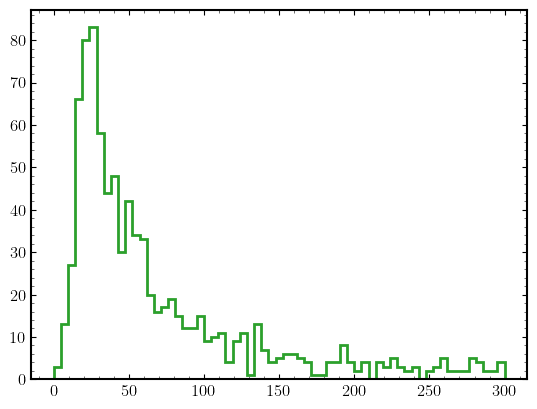

In [52]:
bins = np.linspace(0, 300, 64)
_ = plt.hist(
    w0.physicsspherical.r.value,
    bins=bins,
    histtype="step",
    color="tab:green",
    lw=2,
    label="initial conditions",
)
_ = plt.hist(
    wf.physicsspherical.r.value.T,
    bins=bins,
    histtype="step",
    color="tab:red",
    lw=2,
    label="final positions",
)
plt.legend(loc="best", fontsize=18)

When we chose a DF and start sampling, we'll probably want to decide on some truncation criteria to decide which streams to actually run. For example, a progenitor at 200 kpc that never gets close enough to strip is not worth simulating because it would never form a dense stream. We might want to require that the pericenter radius is < 10 kpc or something. A topic for us to discuss!

In [53]:
pericenters = wf.pericenter()
apocenters = wf.apocenter()

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([ 32.,  91., 100.,  85.,  60.,  53.,  46.,  40.,  28.,  36.,  22.,
         30.,  19.,  13.,  13.,  20.,  15.,  11.,  13.,  12.,   8.,   9.,
          6.,   7.,   8.,   6.,   5.,   3.,   8.,   4.,   6.,   0.,   7.,
          5.]),
 array([  0.        ,   8.82352941,  17.64705882,  26.47058824,
         35.29411765,  44.11764706,  52.94117647,  61.76470588,
         70.58823529,  79.41176471,  88.23529412,  97.05882353,
        105.88235294, 114.70588235, 123.52941176, 132.35294118,
        141.17647059, 150.        , 158.82352941, 167.64705882,
        176.47058824, 185.29411765, 194.11764706, 202.94117647,
        211.76470588, 220.58823529, 229.41176471, 238.23529412,
        247.05882353, 255.88235294, 264.70588235, 273.52941176,
        282.35294118, 291.17647059, 300.        ]),
 <BarContainer object of 34 artists>)

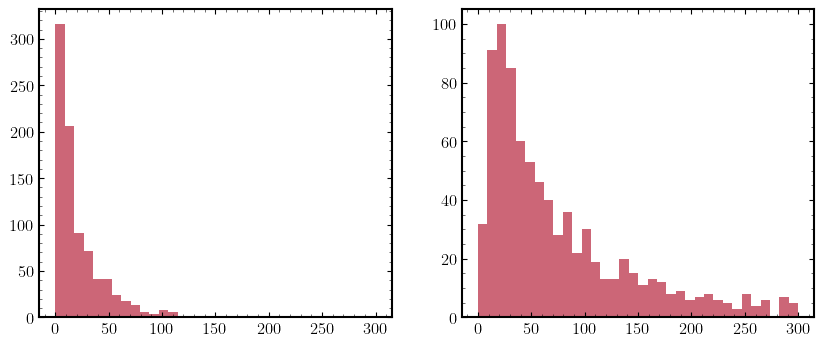

In [54]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(pericenters.value, bins=np.linspace(0,300,35))
ax[1].hist(apocenters.value, bins=np.linspace(0,300,35))

(array([ 0.,  0., 14., 24., 31., 36., 44., 30., 20., 29., 18., 20., 18.,
         4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0.        ,   4.16666667,   8.33333333,  12.5       ,
         16.66666667,  20.83333333,  25.        ,  29.16666667,
         33.33333333,  37.5       ,  41.66666667,  45.83333333,
         50.        ,  54.16666667,  58.33333333,  62.5       ,
         66.66666667,  70.83333333,  75.        ,  79.16666667,
         83.33333333,  87.5       ,  91.66666667,  95.83333333,
        100.        ]),
 <BarContainer object of 24 artists>)

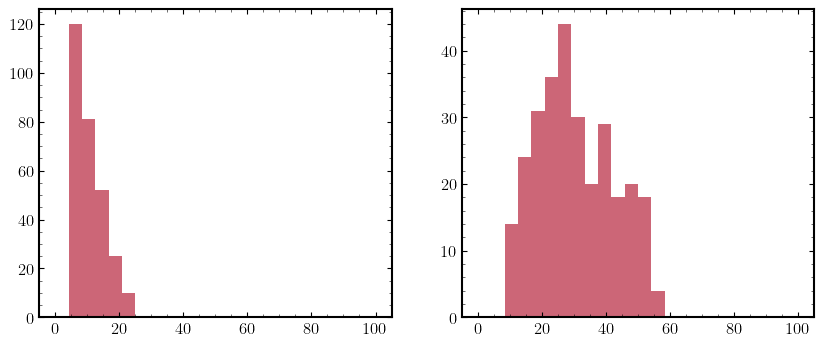

In [55]:
peri_mask = (pericenters < 25*u.kpc) & (pericenters > 5*u.kpc)
apo_mask = (apocenters < 55*u.kpc)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(pericenters.value[peri_mask & apo_mask], bins=np.linspace(0,100,25))
ax[1].hist(apocenters.value[peri_mask & apo_mask], bins=np.linspace(0,100,25))


In [56]:
rng = np.random.default_rng(seed=1)
xv_sample = rng.choice(xv[peri_mask & apo_mask], size=2)
peri_smaple = rng.choice(pericenters[peri_mask & apo_mask], size=2)
apo_smaple = rng.choice(apocenters[peri_mask & apo_mask], size=2)
xv_sample, peri_smaple, apo_smaple

(array([[-8.8267025 , -3.89542224, -0.67336946,  0.00923037, -0.20026371,
          0.01568128],
        [-8.82431583,  5.40395837, -1.41479583, -0.07163239, -0.11387915,
          0.13832626]]),
 array([7.28923798, 7.37483381]),
 array([18.64107567, 33.96076556]))

In [57]:
w0_2 = gd.PhaseSpacePosition.from_w(xv_sample.T + mwh0_xv[:, None], units=galactic)

In [58]:
wf_2 = integrator.run(w0_2,  dt=-1 * u.Myr, t1=0* u.Gyr, t2=-5 * u.Gyr)

In [59]:
wf_2.pericenter(), wf_2.apocenter()

(<Quantity [6.74403527, 8.96630785] kpc>,
 <Quantity [15.0152036 , 13.88201645] kpc>)

In [32]:
# for i in range(len(prog_ics)):
#     yaml_data = {'Tbegin': -5.0, 
#                  'Tfinal': 0.0, 
#                  'dtmin': 0.001, 
#                  'prog_mass': prog_ics[i].tolist()[0],
#                  'prog_scale': prog_ics[i].tolist()[1], 
#                  'prog_ics':xv[i].tolist(),
#                  'strip_rate': 4,
#                  'haloflag': 63,
#                  'lmcflag': 0,
#                  'discflag': 63,
#                  'discframe': False,
#                  'static_mwh': False,
#                  'lmc_switch': True,
#                 'inpath':str("/mnt/home/rbrooks/ceph/oceanus/ics/full-mwh-full-mwd-no-lmc/"),
#                 'snapname':str("param_{}".format(i)),
#                 'outpath':str("/mnt/home/rbrooks/ceph/oceanus/analysis/stream-runs/full-mwh-full-mwd-no-lmc/"),
#                 'outname':str("stream_{}".format(i))}    
#     file_name = f"full-mwh-full-mwd-no-lmc/param_{i}.yaml"
#     with open(file_name, 'w') as yaml_file:
#         yaml.dump(yaml_data, yaml_file, default_flow_style=False)

In [48]:
# import agama
# import astropy.units as u
# import gala.dynamics as gd
# import gala.potential as gp
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import yaml
# import sys

# import numpy as np
# from gala.units import galactic
# agama.setUnits(length=u.kpc, mass=u.Msun, time=u.Myr)

# rng = np.random.default_rng(seed=1)

# def read_mass_scale_params(paramfile):
#     """
#     Read in the stream model parameters
#     """
#     with open(paramfile) as f:
#         d = yaml.safe_load(f)
    
#     IMF = d["IMF"]
#     Noversample = d["Noversample"]
#     Nsample = d["Nsample"]
#     peri_cut = d["peri_cut"]
#     apo_cut = d["apo_cut"]
    
#     return [IMF, Noversample, Nsample, peri_cut, apo_cut]

# def read_pot_params(paramfile):
#     """
#     Read in the stream model parameters
#     """
#     with open(paramfile) as f:
#         d = yaml.safe_load(f)

#     inpath = d["inpath"]
#     outpath = d["outpath"]
#     Tbegin = d["Tbegin"]
#     Tfinal = d["Tfinal"]
#     dtmin  = d["dtmin"]
#     haloflag = d["haloflag"]
#     lmcflag = d["lmcflag"]
#     discflag = d["discflag"]
#     strip_rate = d["strip_rate"]
#     discframe = d["discframe"]
#     static_mwh = d["static_mwh"]
#     mwd_switch = d["mwd_switch"]
#     lmc_switch = d["lmc_switch"]
    
#     return [inpath, outpath, Tbegin, Tfinal, dtmin, 
#            haloflag, discflag, lmcflag, strip_rate, discframe, static_mwh, mwd_switch, lmc_switch]

# def make_ics(params_mass_scale):
    
#     IMF, Noversample, Nsample, peri_cut, apo_cut = params_mass_scale

#     #--------------------------------------------------------------------------------------
#     ### Potential matching L23 (r_s = 12.8kpc, c = 15.3, v_c_solar = 184 km/s, V_vir = ˜130 km/s)
#     #--------------------------------------------------------------------------------------
#     gala_pot = gp.NFWPotential.from_circular_velocity(v_c=184 * u.km / u.s, r_s=8.249 * u.kpc, units=galactic)
#     agama_pot = gala_pot.as_interop("agama")

#     dens = agama.Density(type="Dehnen", scaleRadius=15)
#     df = agama.DistributionFunction(type="QuasiSpherical", potential=agama_pot, density=dens)
#     gm = agama.GalaxyModel(agama_pot, df)

#     #--------------------------------------------------------------------------------------
#     ### Lognormal (final) or truncated lognormal (initial) distribution for the GC masses
#     #--------------------------------------------------------------------------------------
    
#     if IMF==True:
#         lower_bound = 1e4
#         upper_bound = 1e7
#         mu_mass_init = np.log(1e4) #solar masses 
#         std_mass_init = np.log(3)
#         samples_mass_init = rng.lognormal(mu_mass_init, std_mass_init, Noversample)[:,np.newaxis]
#         samples_mass = samples_mass_init[(samples_mass_init > lower_bound) & (samples_mass_init < upper_bound)][:,np.newaxis]
        
#     elif IMF==False:    
#         mu_mass_final = np.log(1e5) #solar masses 
#         std_mass_final = np.log(2)
#         samples_mass = rng.lognormal(mu_mass_final, std_mass_final, Noversample)[:,np.newaxis]

#     #--------------------------------------------------------------------------------------
#     ### All GC scale radii set to 2 pc
#     #--------------------------------------------------------------------------------------
#     samples_scale = np.repeat(0.002, len(samples_mass))[:,np.newaxis]
#     prog_mass_scale = np.concatenate([samples_mass, samples_scale], axis=1)

#     #--------------------------------------------------------------------------------------
#     ### Over-sample from the DF and integrate orbits to be able to find pericenters
#     #--------------------------------------------------------------------------------------
#     xv = gm.sample(len(samples_mass))[0]
#     w0 = gd.PhaseSpacePosition.from_w(xv.T, units=galactic)
#     wf = gala_pot.integrate_orbit(w0, dt=2 * u.Myr, t1=0, t2=5 * u.Gyr, store_all=True) 

#     #--------------------------------------------------------------------------------------
#     ### Cut on the pericentric and apocentric passage conditions
#     #--------------------------------------------------------------------------------------
#     pericenters = wf.pericenter()
#     apocenters = wf.apocenter()
#     peri_mask = (pericenters > peri_cut[0]*u.kpc) & (pericenters < peri_cut[1]*u.kpc)
#     apo_mask = (apocenters < apo_cut*u.kpc)
    
    
#     cut_mass_scales = prog_mass_scale[peri_mask & apo_mask]
#     mass_scales = rng.choice(cut_mass_scales, size=Nsample)
    
#     cut_prog_ics = xv[peri_mask & apo_mask]
#     prog_ics = rng.choice(cut_prog_ics, size=Nsample)
    
#     peris = pericenters[peri_mask & apo_mask]
#     apos = apocenters[peri_mask & apo_mask]
    

#     return prog_ics, mass_scales, peris, apos


# def streamparams(ics, mass_scales, peris, apos):
    
#     exts = ["rm-mwh-full-mwd-full-lmc", "em-mwh-full-mwd-full-lmc", "md-mwh-full-mwd-full-lmc", \
#           "mq-mwh-full-mwd-full-lmc", "mdq-mwh-full-mwd-full-lmc",  "full-mwh-full-mwd-full-lmc", "full-mwh-full-mwd-no-lmc"]
    
#     gens = ["gen-params-rm-mwh-mwd-lmc.yaml", "gen-params-em-mwh-mwd-lmc.yaml", "gen-params-md-mwh-mwd-lmc.yaml",
#            "gen-params-mq-mwh-mwd-lmc.yaml", "gen-params-mdq-mwh-mwd-lmc.yaml", "gen-params-full-mwh-mwd-lmc.yaml",
#            "gen-params-full-mwh-mwd-no-lmc.yaml"]
    
#     path = "/mnt/ceph/users/rbrooks/oceanus/ics/generation-files/"
    
#     for j in range(len(exts)): 
        
#         print("* Saving data in {}".format("/mnt/ceph/users/rbrooks/oceanus/ics/" + exts[j]))
          
#         inpath, outpath, Tbegin, Tfinal, dtmin, \
#         haloflag, discflag, lmcflag, strip_rate, \
#         discframe, static_mwh, mwd_switch, lmc_switch = read_pot_params(path + gens[j])
            
#         for i in range(len(ics)):
#             yaml_data = {'Tbegin': Tbegin, 
#                          'Tfinal': Tfinal, 
#                          'dtmin': dtmin, 
#                          'prog_mass': mass_scales[i].tolist()[0],
#                          'prog_scale': mass_scales[i].tolist()[1], 
#                          'prog_ics': ics[i].tolist(),
#                          'pericenter': peris[i].value.tolist(),
#                          'apocenter': apos[i].value.tolist(),
#                          'strip_rate': strip_rate,
#                          'haloflag': haloflag,
#                          'lmcflag': lmcflag,
#                          'discflag': discflag,
#                          'discframe': discframe,
#                          'static_mwh': static_mwh,
#                          'mwd_switch': mwd_switch,
#                          'lmc_switch': lmc_switch, 
#                         'inpath':inpath,
#                         'snapname':str("param_{}".format(i)),
#                         'outpath':outpath,
#                         'outname':str("stream_{}".format(i))}
#             file_name = f"/mnt/home/rbrooks/ceph/oceanus/ics/{exts[j]}/param_{i}.yaml"
#             with open(file_name, 'w') as yaml_file:
#                 yaml.dump(yaml_data, yaml_file, default_flow_style=False)

In [49]:
#-----------------------------------------------------------------------------------------    
# Run the script - python initialconditions.py mass-scale.yaml gen-params...yaml 
#-----------------------------------------------------------------------------------------  

# params_mass_scales = read_mass_scale_params("generation-files/mass-scale.yaml")   
# prog_ics, mass_scales, peris, apos = make_ics(params_mass_scales)

In [50]:
# streamparams(prog_ics, mass_scales, peris, apos)